# 1. Preprocessing

In [1]:
# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
import math
from statsmodels.tsa.deterministic import DeterministicProcess

In [2]:
# Ignore Future Warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Setup
train = pd.read_csv('train.csv', parse_dates=["date"])
test = pd.read_csv('test.csv', parse_dates=["date"])

In [4]:
print(train.shape, test.shape)
# train.head()
# test.head()

(3000888, 6) (28512, 5)


In [5]:
# Error Function (RMSLE)
def error(y_p, y_t):
    # y_p: predictted (fitted)
    # y_t: test (actual)
    pred_log = np.array([math.log(i+1) for i in np.nditer(y_p)])
    act_log = np.array([math.log(i+1) for i in np.nditer(y_t)])
    dum_error = sum((pred_log - act_log)**2)/len(pred_log)
    linear_error = np.power(dum_error, 1/2)
    return round(linear_error, 4)

## Blue print

1. Make subsets for each family
2. Separate train data set into "ourtrain" and "ourtest" (**sorted**, 70:30)
3. Apply ML models to all subsets
4. Compute total error from all subsets
5. Choose the ML model which gives the min error
6. Apply to the test data set

### - Check Correlation

In [6]:
# Check if we can drop 'store_nbr' and 'onpromotion'
train.corr()

,id,store_nbr,sales,onpromotion
id,1.000000,0.000301,0.085784,0.206260
store_nbr,0.000301,1.000000,0.041196,0.007286
sales,0.085784,0.041196,1.000000,0.427923
onpromotion,0.206260,0.007286,0.427923,1.000000


**Comment**: 'store_nbr' has weak correlation(0.04), and 'onpromotion' has moderate correlation(0.43) with 'sales'. We will drop thoes two columns and focus on prediction based on time.

In [7]:
# Drop 'store_nbr' and 'onpromotion'
train = train.drop(['store_nbr','onpromotion'], axis=1)
test = test.drop(['store_nbr','onpromotion'], axis=1)
test.head()

,id,date,family
0,3000888,2017-08-16,AUTOMOTIVE
1,3000889,2017-08-16,BABY CARE
2,3000890,2017-08-16,BEAUTY
3,3000891,2017-08-16,BEVERAGES
4,3000892,2017-08-16,BOOKS


# 2. Make subsets of each family

In [8]:
# Check unique values of "family"
family_list = train["family"].unique()
print(family_list, "\nNumber of unique values:", len(family_list))

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD'] 
Number of unique values: 33


In [9]:
# Generates subsets for each family
def generate_subsets(family):
    subset = train.loc[train['family']==family, :]
    return subset

# Save the subsets in dictionary
subsets = {}
for family in family_list:
    subsets.update({family:generate_subsets(family)})

# # Check
# subsets['GROCERY II'].head()

In [10]:
# Extracts features
def ext_features(df):
    return df.drop(['sales'], axis=1)

# Extracts targets
def ext_targets(df):
    return df['sales']

In [11]:
# Separate "train" data set into "ourtrain" and "ourtest" (sorted, 70:30)
from sklearn.model_selection import train_test_split

# Splits the tain data into 70:30
def split_train(df):
    return train_test_split(df, test_size=0.3, random_state=None, shuffle=False)

# # Generate 'ourtrain' and 'ourtest'
# ourtrain, ourtest = split_train(train)

### - Check plots for each subsets

In [12]:
# Make a plot
def make_plot(key, ax):
    ourtrain, ourtest = split_train(subsets[key])
    train = ourtrain[['date', 'sales']].set_index("date").to_period("D")
    test = ourtest[['date', 'sales']].set_index("date").to_period("D")
    
    train[:].plot(ax=ax, figsize=(20,10), style=".", color="0.5")
    ax = test[:].plot(ax=ax, style=".", color="0.8")

    ax.set_title("Store Sales - {family}".format(family=key), fontsize=20)
    trendlabels = ['Train', 'Test']
    _ = ax.legend(labels=trendlabels, prop={'size': 14})
    _ = plt.xlabel("Dates", size=14)
    _ = plt.ylabel("Sales", size=14)

    plt.tight_layout()  
    
    return ax

In [13]:
# Check 3 plots at a time
def mul_plots(first, second, third):
    subsets_fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))
    make_plot(first, ax=ax1)
    make_plot(second, ax=ax2)
    make_plot(third, ax=ax3)

    return ax1, ax2, ax3

(<AxesSubplot:title={'center':'Store Sales - BEVERAGES'}, xlabel='date'>,
 <AxesSubplot:title={'center':'Store Sales - BOOKS'}, xlabel='date'>,
 <AxesSubplot:title={'center':'Store Sales - BREAD/BAKERY'}, xlabel='Dates', ylabel='Sales'>)

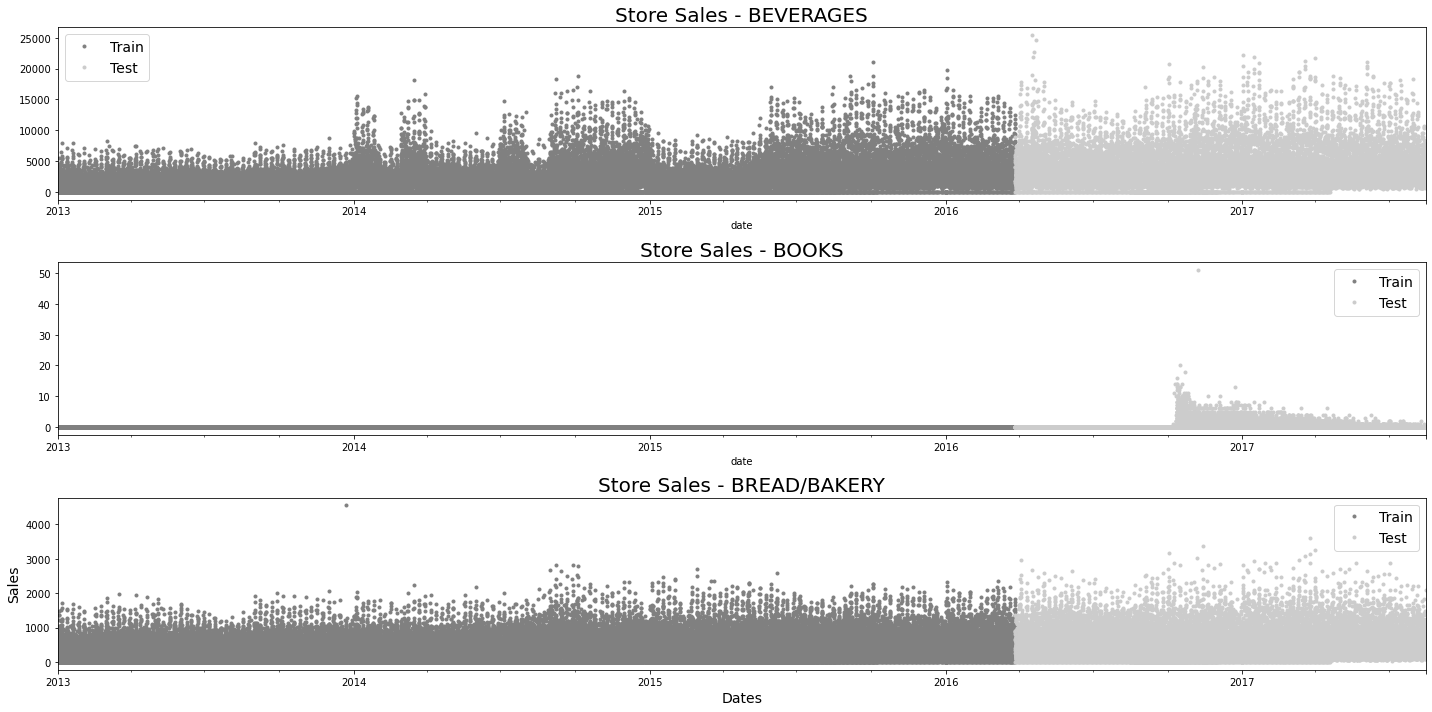

In [14]:
mul_plots('BEVERAGES', 'BOOKS', 'BREAD/BAKERY')

# 4. Apply ML models

### 1) Trend

In [15]:
# Fit data to trend model
def trend(ourtrain, ourtest, error):  

    # Modify data format
    train = ourtrain[['date', 'sales']].set_index("date").to_period("D")
    test = ourtest[['date', 'sales']].set_index("date").to_period("D")

    # Targets
    y_train = ext_targets(train)
    y_test = ext_targets(test)
    
    # Create features
    trend_dp = DeterministicProcess(
    index=train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
    )

    # `in_sample` creates features for the dates given in the `index` argument
    X_train = trend_dp.in_sample()

    # Fit model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_pre = pd.Series(model.predict(X_train), index=X_train.index)

    # Out of Sample 
    X_oos = trend_dp.out_of_sample(steps=len(test.index))
    y_fore = pd.Series(model.predict(X_oos), index=X_oos.index)

    # # Plot
    # ax = train[:].plot(figsize=(20,10), linewidth=0.5, marker="o", markersize=2, color="0.5")
    # ax = y_pre[:].plot(ax=ax, linewidth=3, label="Trend")
    # ax = test[:].plot(ax=ax, linewidth=0.5, marker="o", markersize=2, color="0.8")
    # ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")

    # ax.set_title("Store Sales - Linear Trend Forecast", fontsize=20)
    # trendlabels = ['Actual Sales in Train', 'Trend', 'Actual Sales in Test', 'Trend Forecast']
    # _ = ax.legend(labels=trendlabels, prop={'size': 14})
    # _ = plt.xlabel("Id", size=14)
    # _ = plt.ylabel("Sales", size=14)

    return error(y_fore, y_test)


In [16]:
# Compute errors of all subsets
trend_errors = []
for key in family_list:
    ourtrain, ourtest = split_train(subsets[key])
    trend_errors.append(trend(ourtrain, ourtest, error))

In [17]:
print("Total Error from Trend model: ", round(sum(trend_errors), 4))

Total Error from Trend model:  39.6358


### 2) Periodogram

In [18]:
# Make "date" as index
def by_date(key):
    df= subsets[key].groupby(by="date").sum()
    df = pd.DataFrame(df['sales'])
    df = df.to_period('D')

    return df

In [19]:
# Generate a dictionary of "date"-indexed subsets
d_subsets = {}

for family in family_list:
    d_subsets.update({family:by_date(family)})

In [ ]:
# Add seasonal features(day, week, dayofyear, year)
def 

### 3) Cycles

### 4) Hybrid _ Direct Strategy

# 5. Choose the ML model which gives the min error